In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [2]:
# Nicer plotting
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (8,4)

# Autophase and Autophase and Scale examples

In [3]:
from impact import Impact, template_dir

import numpy as np
import os

In [4]:
ifile = os.path.join(template_dir,'lcls_injector/ImpactT.in')
os.path.exists(ifile)

True

In [5]:
# Make Impact object
I = Impact(ifile, verbose=True)

Configured to run in: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpfd7gizts


# Phase and Scale the LCLS gun

In [6]:
from impact.autophase import autophase_and_scale

from pmd_beamphysics import single_particle

P0 = single_particle(pz=1e-15, z=1e-15)

In [7]:
autophase_and_scale(I, phase_ele_name='GUN', target=6e6, scale_range=(10e6, 100e6), initial_particles=P0, verbose=True)

Copied initial Impact object. 
Phasing GUN by changing theta0_deg
Scaling GUN by changing rf_field_scale
Bounds: 0.0, 0.15 m
Disabling SOL1
Disabling L0A_entrance
Disabling L0A_body_1
Disabling L0A_body_2
Disabling L0A_exit
Disabling L0B_entrance
Disabling L0B_body_1
Disabling L0B_body_2
Disabling L0B_exit
Default brent2 algorithm
Phase: 180, Scale: 10000000.0, 0.0 M
Phase: 180, Scale: 10000000.0, 0.0 M
Phase: 42.49224000000004, Scale: 10000000.0, 0.0 M
Phase: 180, Scale: 10000000.0, 0.0 M
Phase: 42.49223094384001, Scale: 10000000.0, 0.0 M
Phase: 179.9999944029853, Scale: 10000000.0, 0.0 M
Phase: 264.9844674846946, Scale: 10000000.0, 0.0 M
Phase: 317.5077613212758, Scale: 10000000.0, 0.8975755210250457 MeV
Phase: 349.96894270427333, Scale: 10000000.0, 0.0 M
Phase: 307.47670509448403, Scale: 10000000.0, 1.0654409944367191 MeV
Phase: 291.24611506362317, Scale: 10000000.0, 1.2336237324429469 MeV
Phase: 278.009842672294, Scale: 10000000.0, 1.2963959157049125 MeV
Phase: 272.1943937752485, S

(304.83485070005105, 47541430.82645669)

In [8]:
# Check this:
I.verbose=False
PF = I.track(P0, s=0.15)
PF['mean_energy']

6000000.0520619815

In [9]:
# Examine this process using the debug flag. This will return the function used for phasing and scaling. 
ps_f, Itest = autophase_and_scale(I, phase_ele_name='GUN', target=6e6, initial_particles=P0, verbose=False,
                     debug = True)


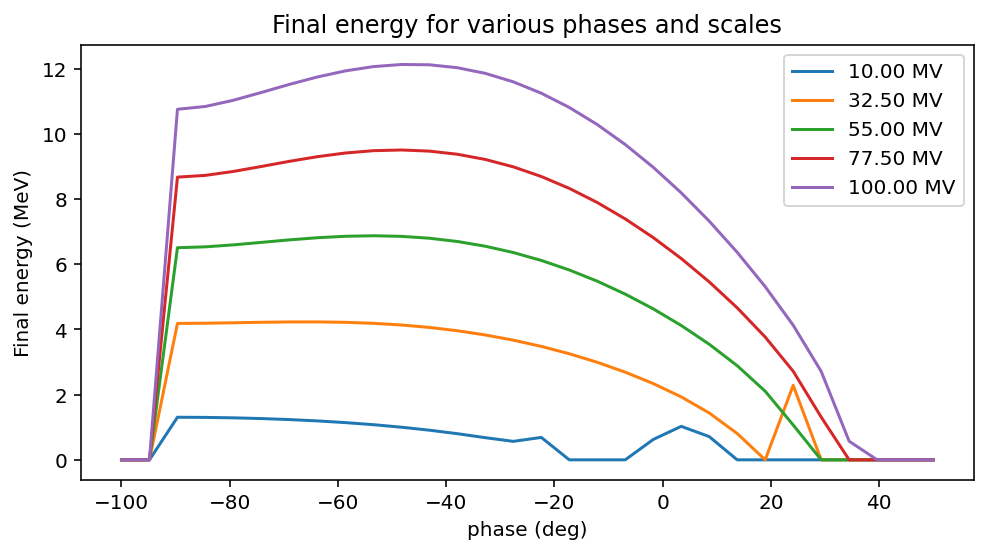

In [10]:
# Phases to try
ptry = np.linspace(-100, 50, 30)

# scales to try
for sc in np.linspace(10e6, 100e6, 5):
    res = np.array([ps_f(p, sc)/1e6 for p in ptry])
    plt.plot(ptry, res, label=f'{sc/1e6:0.2f} MV')
plt.title('Final energy for various phases and scales')
plt.ylabel('Final energy (MeV)')
plt.xlabel('phase (deg)')
plt.legend()

In [11]:
# 3D plot

# Make data.
X = np.linspace(-100, 50, 10)
Y = np.linspace(10e6, 100e6, 10)
X, Y = np.meshgrid(X, Y)
@np.vectorize
def f(phase, scale):
    return ps_f(phase, scale)
Z = f(X, Y)

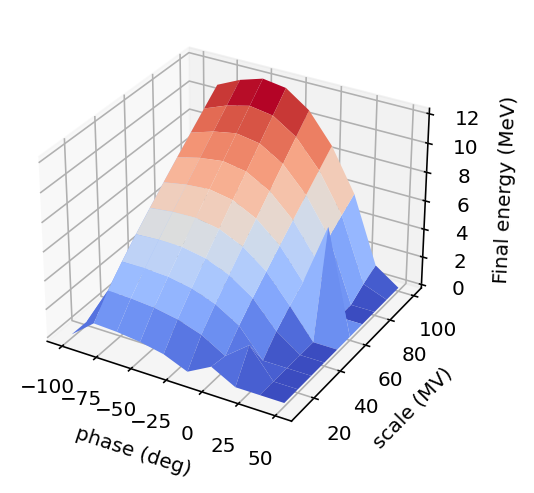

In [12]:
# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y/1e6, Z/1e6, cmap=matplotlib.cm.coolwarm,
                       linewidth=0, antialiased=True)

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('phase (deg)')
ax.set_ylabel('scale (MV)')
ax.set_zlabel('Final energy (MeV)')
plt.show()



# Phase and scale LCLS linac sections 

Linacs L0A and L0B are special, because they require 4 fieldmaps each to model the travelling wave structure. To tune these together, we need to add control groups

In [13]:
#  Changes in phases
I.add_group('L0A', ele_names=['L0A_entrance', 'L0A_body_1', 'L0A_body_2', 'L0A_exit'], var_name='theta0_deg', attributes='theta0_deg')
I.add_group('L0B', ele_names=['L0B_entrance', 'L0B_body_1', 'L0B_body_2', 'L0B_exit'], var_name='theta0_deg', attributes='theta0_deg')

# Overall scaling, respecting the special factors. 
I.add_group('L0A_scale', ele_names=['L0A_entrance', 'L0A_body_1', 'L0A_body_2', 'L0A_exit'],
                   var_name = 'rf_field_scale',
                  factors = [0.86571945106805, 1, 1, 0.86571945106805],  # sin(k*d) with d = 3.5e-2 m 
                  absolute=True)

# Overall scaling, respecting the special factors. 
I.add_group('L0B_scale', ele_names=['L0B_entrance', 'L0B_body_1', 'L0B_body_2', 'L0B_exit'],
                   var_name = 'rf_field_scale',
                  factors = [0.86571945106805, 1, 1, 0.86571945106805],  # sin(k*d) with d = 3.5e-2 m 
                  absolute=True)

I['L0A_scale']['rf_field_scale'] = 30e6
#I['L0A_scale'].__dict__



In [14]:
# L0A to 64 MeV

res_L0A = autophase_and_scale(I, phase_ele_name='L0A', scale_ele_name='L0A_scale', target=64e6, scale_range=(10e6, 100e6), initial_particles=P0, verbose=True)

Copied initial Impact object. 
Phasing L0A by changing theta0_deg
Scaling L0A_scale by changing rf_field_scale
Bounds: 1.485, 4.527856 m
Tracking initial particles to s = 1.485
Initial particle:  1.48497552983 6000000.0520619815
Disabling GUN
Disabling SOL1
Disabling L0B_entrance
Disabling L0B_body_1
Disabling L0B_body_2
Disabling L0B_exit
Default brent2 algorithm
Phase: 180, Scale: 10000000.0, 14.028257361251201 MeV
Phase: 180, Scale: 10000000.0, 14.028257361251201 MeV
Phase: 42.49224000000004, Scale: 10000000.0, 21.295102080160497 MeV
Phase: 264.9844890561601, Scale: 10000000.0, 7.953368771269836 MeV
Phase: 42.49224000000004, Scale: 10000000.0, 21.295102080160497 MeV
Phase: 42.49223440298533, Scale: 10000000.0, 21.29510328787956 MeV
Phase: 264.9844709438398, Scale: 10000000.0, 7.9533669878245 MeV
Phase: 222.49225349543042, Scale: 10000000.0, 11.3136800000378 MeV
Phase: 127.47670402554945, Scale: 10000000.0, 7.237186072827997 MeV
Phase: 333.73836169565016, Scale: 10000000.0, 22.502447

In [15]:
autophase_and_scale(I, phase_ele_name='L0B', scale_ele_name='L0B_scale', target=135e6, scale_range=(10e6, 100e6), initial_particles=P0, verbose=True)

Copied initial Impact object. 
Phasing L0B by changing theta0_deg
Scaling L0B_scale by changing rf_field_scale
Bounds: 5.328756, 8.371612 m
Tracking initial particles to s = 5.328756
Initial particle:  5.32879450701 63999929.18302853
Disabling GUN
Disabling SOL1
Disabling L0A_entrance
Disabling L0A_body_1
Disabling L0A_body_2
Disabling L0A_exit
Default brent2 algorithm
Phase: 180, Scale: 10000000.0, 44.74104525262646 MeV
Phase: 180, Scale: 10000000.0, 44.74104525262646 MeV
Phase: 42.49224000000004, Scale: 10000000.0, 79.0965196027771 MeV
Phase: 264.9844890561601, Scale: 10000000.0, 61.00519007641767 MeV
Phase: 42.49224000000004, Scale: 10000000.0, 79.0965196027771 MeV
Phase: 42.49223440298533, Scale: 10000000.0, 79.09652077857507 MeV
Phase: 264.9844709438398, Scale: 10000000.0, 61.00518405188008 MeV
Phase: 222.4922489001101, Scale: 10000000.0, 48.91580417718563 MeV
Phase: 127.47670402554945, Scale: 10000000.0, 53.32350323903612 MeV
Phase: 333.73835994039405, Scale: 10000000.0, 80.68397

(3.983259077279564, 36780527.3869102)

In [16]:
I.track(P0, s=8.371612)['mean_energy']

134999242.34070167

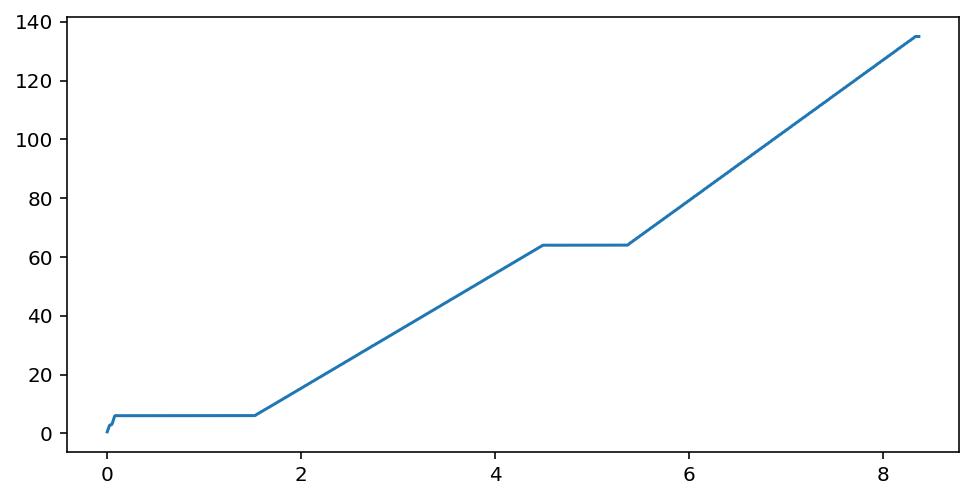

In [17]:
plt.plot(I.stat('mean_z'), I.stat('mean_kinetic_energy')/1e6 + 0.511)

# Autophase without scaling

Just phasing is simpler.

In [18]:
from impact.autophase import autophase


ifile2 = os.path.join(template_dir,'apex_gun/ImpactT.in')

I2 = Impact(ifile2, verbose=False)

In [19]:
autophase(I2, ele_name='APEX_GUN', initial_particles=P0, metric='mean_kinetic_energy', verbose=True)

Copied initial Impact object. 
Phasing APEX_GUN by changing theta0_deg
Bounds: 0.0, 0.199 m
Disabling SOL1
Default brent2 algorithm
Phase: 180, 0.7501400260547707 MeV
Phase: 180, 0.7501400260547707 MeV
Phase: 42.49224000000004, 0.0 M
Phase: 180, 0.7501400260547707 MeV
Phase: 42.49223094384001, 0.0 M
Phase: 42.49223999999998, 0.0 M
Phase: 222.49223547192, 0.46487921649929437 MeV
Phase: 151.59398241178104, 0.714711059468071 MeV
Phase: 171.3511003792883, 0.7585459504017038 MeV
Phase: 171.34908462106745, 0.7585459029872261 MeV
Phase: 171.4523027473299, 0.7585471358806966 MeV
Phase: 171.45289970740637, 0.7585471359181192 MeV
Phase: 171.45272825449666, 0.7585471359181192 MeV
Phase: 171.45255680175842, 0.7585471359087637 MeV
Set Phase: 171.45272825449666


171.45272825449666

In [20]:
phase_f, Itest = autophase(I2, ele_name='APEX_GUN', metric='mean_kinetic_energy', initial_particles=P0, debug = True)

Text(0.5, 0, 'phase (deg)')

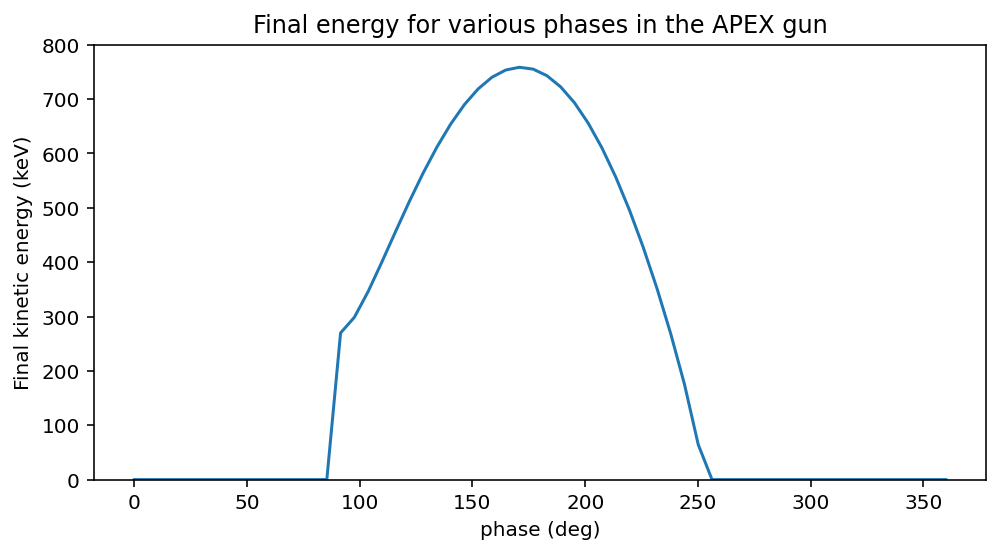

In [21]:
# Phases to try
ptry = np.linspace(0, 360, 60)

energies = np.array([phase_f(p)/1e3 for p in ptry]) 

plt.plot(ptry, energies)
plt.ylim(0, 800)
plt.title('Final energy for various phases in the APEX gun')
plt.ylabel('Final kinetic energy (keV)')
plt.xlabel('phase (deg)')


# Autophase with alternative metric, and bunch tracking with space charge.

The above uses `mean_energy` as the metric to maximize. Alternatively, one might want to minimize energy spread. This is accomplished by passing `maximize=False` and  `metric='sigma_pz'` or similar.

In [22]:
from distgen import Generator


ifile = os.path.join(template_dir,'lcls_injector/ImpactT.in')
gfile = os.path.join(template_dir,'lcls_injector/distgen.yaml')

G = Generator(gfile)
G['n_particle'] = 2000
G.run()
P0 = G.particles


In [23]:
%%time
I = Impact(ifile, initial_particles=P0, verbose=False)
I.stop = 0.16
I.run()

CPU times: user 142 ms, sys: 39 ms, total: 181 ms
Wall time: 18.6 s


In [24]:
phase_f, Itest = autophase(I, ele_name='GUN', metric='sigma_pz', maximize=False, initial_particles=P0, debug = True, verbose=True)

Copied initial Impact object. 
Phasing GUN by changing theta0_deg
Bounds: 0.0, 0.15 m
Disabling SOL1
Disabling L0A_entrance
Disabling L0A_body_1
Disabling L0A_body_2
Disabling L0A_exit
Disabling L0B_entrance
Disabling L0B_body_1
Disabling L0B_body_2
Disabling L0B_exit


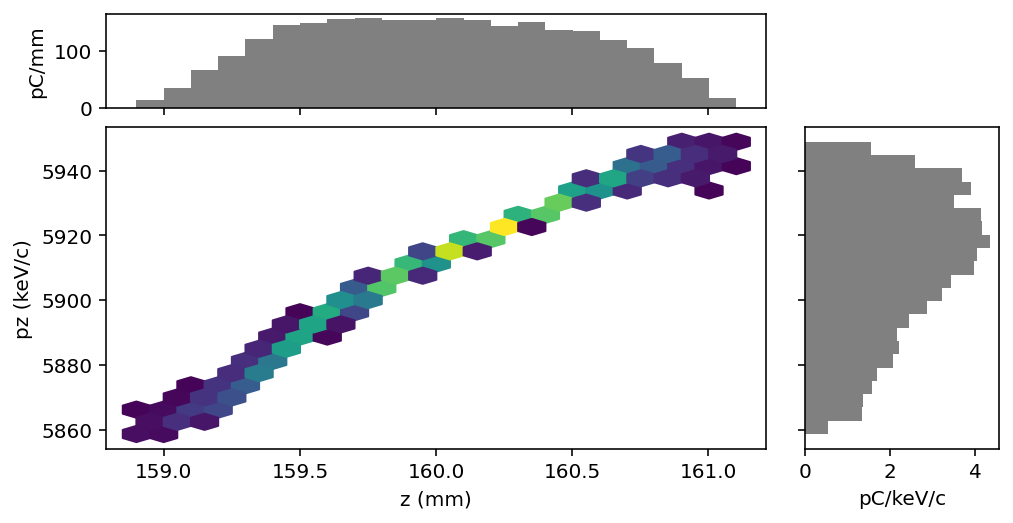

In [25]:
I.particles['final_particles'].plot('z', 'pz')

Phase: 290.0, 0.007535152813650159 MeV/c
Phase: 291.05263157894734, 0.005576525016506006 MeV/c
Phase: 292.10526315789474, 0.0038743541027636452 MeV/c
Phase: 293.1578947368421, 0.002884969196447155 MeV/c
Phase: 294.2105263157895, 0.003312659857976962 MeV/c
Phase: 295.2631578947368, 0.004795213086031761 MeV/c
Phase: 296.3157894736842, 0.006668205842488615 MeV/c
Phase: 297.36842105263156, 0.008692063238513278 MeV/c
Phase: 298.42105263157896, 0.01078560876946653 MeV/c
Phase: 299.4736842105263, 0.012925048925500412 MeV/c
Phase: 300.5263157894737, 0.015101636787342798 MeV/c
Phase: 301.57894736842104, 0.017304052222068336 MeV/c
Phase: 302.63157894736844, 0.019535843274140128 MeV/c
Phase: 303.6842105263158, 0.021789209512393045 MeV/c
Phase: 304.7368421052632, 0.024066619172216558 MeV/c
Phase: 305.7894736842105, 0.02637081219054039 MeV/c
Phase: 306.8421052631579, 0.02869529002064727 MeV/c
Phase: 307.89473684210526, 0.031046450332054696 MeV/c
Phase: 308.9473684210526, 0.03342084100754312 MeV/c
P

Text(0.5, 0, 'phase (deg)')

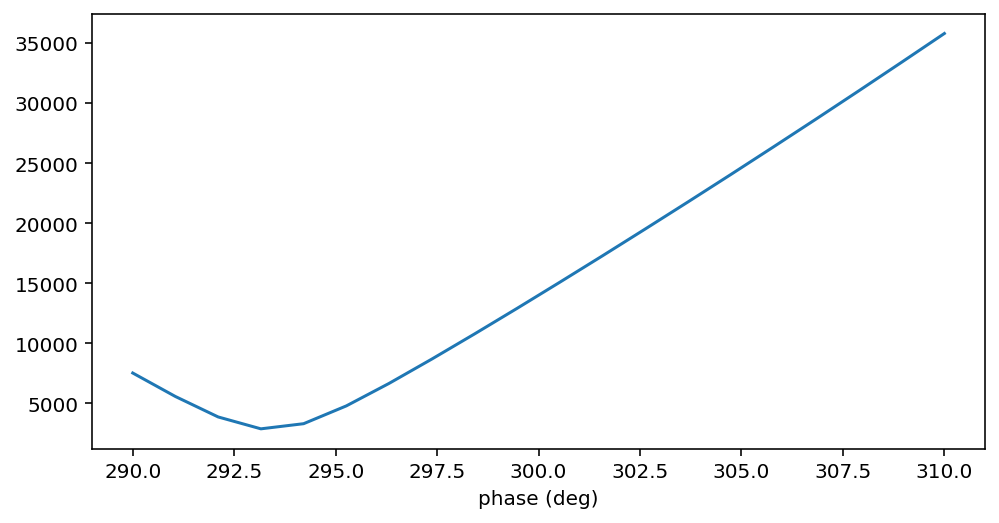

In [26]:
# Phases to try
ptry = np.linspace(290, 310, 20)

sigma_pzs = np.array([phase_f(p) for p in ptry]) 

plt.plot(ptry, sigma_pzs)
#plt.ylim(0, 800)
#plt.title('Final energy for various phases in the APEX gun')
#plt.ylabel('Final kinetic energy (keV)')
plt.xlabel('phase (deg)')



In [27]:
phase_f(293.5)

Phase: 293.5, 0.0028567704624316557 MeV/c


2856.7704624316557

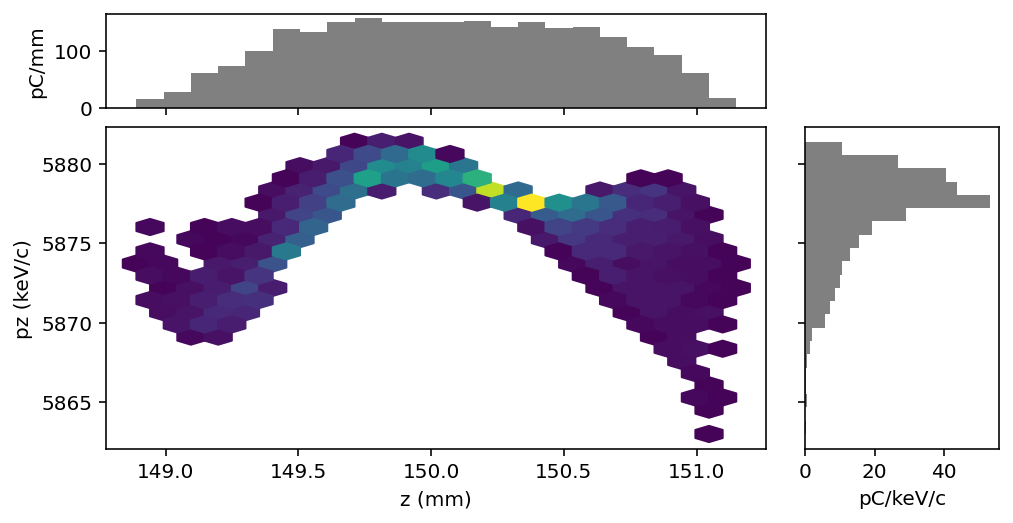

In [28]:
Itest.particles['final_particles'].plot('z', 'pz')

Copied initial Impact object. 
Phasing GUN by changing theta0_deg
Bounds: 0.0, 1.45 m
Disabling SOL1
Disabling L0A_entrance
Disabling L0A_body_1
Disabling L0A_body_2
Disabling L0A_exit
Disabling L0B_entrance
Disabling L0B_body_1
Disabling L0B_body_2
Disabling L0B_exit
Phase: 270.0, 0.05509002209438696 MeV/c
Phase: 270.6896551724138, 0.05086590149797311 MeV/c
Phase: 271.37931034482756, 0.04766139224423593 MeV/c
Phase: 272.0689655172414, 0.04571318644957619 MeV/c
Phase: 272.7586206896552, 0.04172733244660202 MeV/c
Phase: 273.44827586206895, 0.037786535025719936 MeV/c
Phase: 274.13793103448273, 0.03261640893648039 MeV/c
Phase: 274.82758620689657, 0.026871664765318833 MeV/c
Phase: 275.51724137931035, 0.025396354764947456 MeV/c
Phase: 276.2068965517241, 0.021771155053749207 MeV/c
Phase: 276.8965517241379, 0.019248715930866737 MeV/c
Phase: 277.58620689655174, 0.019140522837884144 MeV/c
Phase: 278.2758620689655, 0.01821520829169672 MeV/c
Phase: 278.9655172413793, 0.0175520511451275 MeV/c
Phas

Text(0.5, 0, 'phase (deg)')

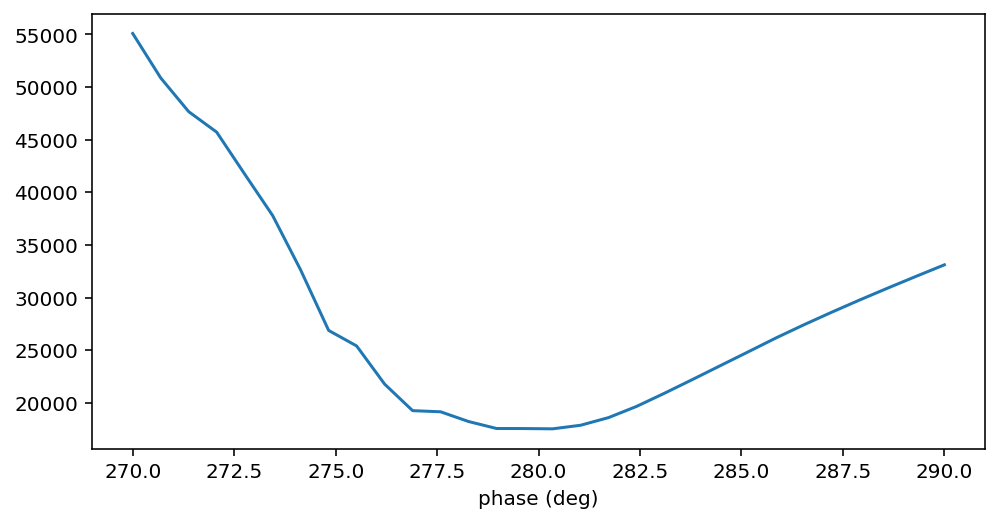

In [29]:
phase_f, Itest = autophase(I, ele_name='GUN', metric='sigma_pz',
                           maximize=False, initial_particles=P0, debug = True,
                           s_stop = 1.45,
                           verbose=True)
# Phases to try
ptry = np.linspace(270, 290, 30)

sigma_pzs = np.array([phase_f(p) for p in ptry]) 

plt.plot(ptry, sigma_pzs)
#plt.ylim(0, 800)
#plt.title('Final energy for various phases in the APEX gun')
#plt.ylabel('Final kinetic energy (keV)')
plt.xlabel('phase (deg)')

In [30]:
phase_f(280.0)

Phase: 280.0, 0.017642553678899258 MeV/c


17642.553678899258

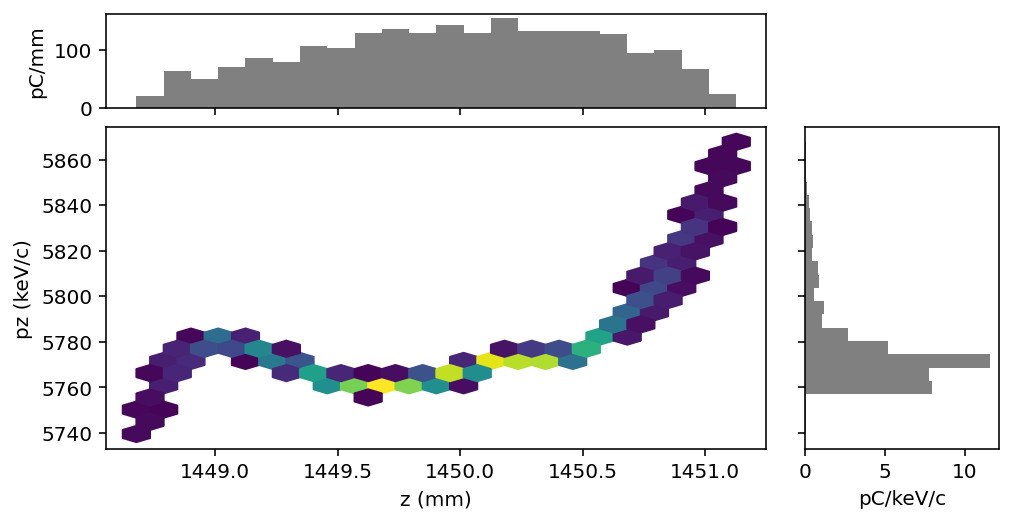

In [31]:
Itest.particles['final_particles'].plot('z', 'pz')